In [12]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [10]:
#confirms torch install
print("Torch version: ", torch.__version__)
#is GPU usable/CPU is fine for MNIST
print("CUDA available: ", torch.cuda.is_available())

Torch version:  2.9.1
CUDA available:  False


In [17]:
#improves training stability
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [16]:
train_dataset = datasets.MNIST(
    root = "./data",
    train = True,
    download = True,
    transform = transform
)

test_dataset = datasets.MNIST(
    root = "./data",
    train = False,
    download = True,
    transform = transform
)

100%|██████████████████████████████████████| 9.91M/9.91M [00:00<00:00, 10.9MB/s]
100%|██████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]
100%|██████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 7.21MB/s]
100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.92MB/s]


(-0.5, 27.5, 27.5, -0.5)

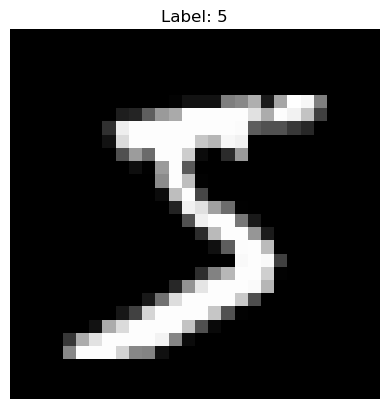

In [24]:
image, label = train_dataset[0]

plt.imshow(image.squeeze(), cmap = "gray")
plt.title(f"Label: {label}")
plt.axis("off")

In [28]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 64,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 64,
    shuffle = False
)

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # First layer: 784 inputs --> 128 hidden units
        self.fc1 = nn.Linear(28*28, 128)

        # Output layer: 128 --> 10 classes (digits 0-9)
        self.fc2 = nn.Linear(128, 10)

    # How data flows through the model
    def forward(self, x):
        # Flatten image: [batch, 1, 28, 28] --> [batch, 784]
        x = x.view(x.size(0), -1)

        # Hidden layer + activation
        x = F.relu(self.fc1(x))

        #Output layer (raw scores, NOT probabilities)
        x = self.fc2(x)

        return x

In [36]:
model = DigitClassifier()

In [38]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [48]:
# number of times the model will see the entire training dataset
epochs = 5

# Outer loop: runs once per epoch
for epoch in range(epochs):

    # Keeps track of total loss for this epoch
    total_loss = 0

    # Inner loop: goes through the dataset in batches
    # images = batch of digit images
    # labels = correct digit (0-9) for each image
    for images, labels in train_loader:
        # 1) clear old gradients from previous step
        # Pytorch accumulates gradients unless we reset them
        optimizer.zero_grad()

        # 2) Forward pass
        # Send images through the neural network to get predictions
        outputs = model(images)

        # 3) Compute loss
        # Compares predictions to correct labels
        # Lower loss = better performance
        loss = criterion(outputs, labels)

        # 4) Backpropagation
        # Computed gradients (how each should change)
        loss.backward()

        # 5) Update model weights
        # Optimizer uses gradients to adjust weights
        optimizer.step()

        # this batch total loss + total loss
        total_loss += loss.item()


    # Print progress after each epoch
    print(f"Epoch [{epoch+1}/{epoch}], Loss: {total_loss:.4f}")

Epoch [1/0], Loss: 362.5745
Epoch [2/1], Loss: 192.0678
Epoch [3/2], Loss: 140.3607
Epoch [4/3], Loss: 111.3071
Epoch [5/4], Loss: 95.7729


In [56]:
epochs = 5 # number of full passes through the dataset

for epoch in range(epochs):
    total_loss = 0 # track loss for this epoch

    # loop over random batches
    for images, labels in train_loader:

        # 1) clear gradients from previous step
        optimizer.zero_grad()

        # 2) forward pass: model makes predictions
        outputs = model(images)

        # 3) compute loss (how wrong the predictions are)
        loss = criterion(outputs, labels)

        # 4) backpropagation: compute gradients
        loss.backward()

        # 5) update weights using optimizer
        optimizer.step()

        # accumulate loss
        total_loss += loss.item()

    # print progress after each epoch
    print(f"Epoch{epoch+1}/epoch{epochs}, Loss: {total_loss:.4f}")

Epoch1/epoch5, Loss: 83.5164
Epoch2/epoch5, Loss: 70.7175
Epoch3/epoch5, Loss: 63.4303
Epoch4/epoch5, Loss: 60.2575
Epoch5/epoch5, Loss: 53.5501


In [58]:
# Put model in evaluation mode
model.eval()

correct = 0
total = 0

# Disable gradient calculations (faster + safer)
with torch.no_grad():
    for images, labels in test_loader:

        # Forward pass (prediction only_
        outputs = model(images)

        # Get predicted digit (index of largest score)
        _, predicted = torch.max(outputs, 1)

        # Count correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.45%


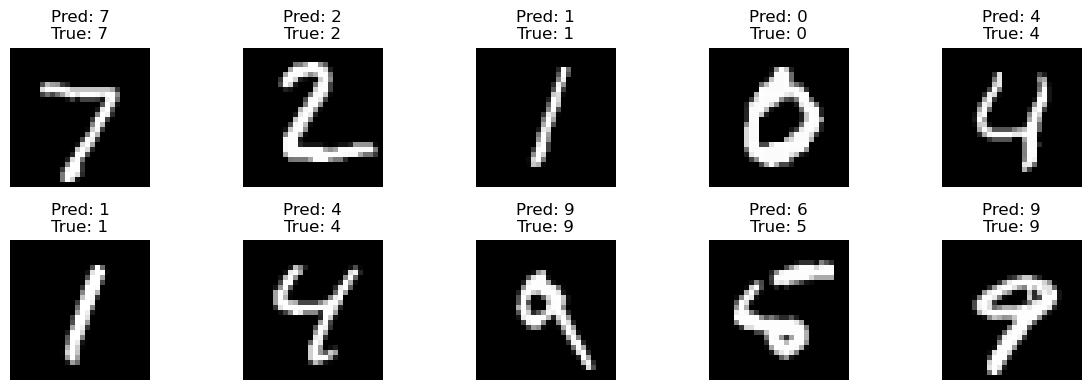

In [67]:
import matplotlib.pyplot as plt

# Put model in evaluation mode
model.eval()

# Get one batch of test data
images, labels = next(iter(test_loader))

# Make predictions
with torch.no_grad():
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

# Plot first 10 predictions
plt.figure(figsize = (12, 4))

for i in range(10): 
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap = "gray")
    plt.title(f"Pred: {predictions[i].item()}\nTrue: {labels[i].item()}")
    plt.axis("off")

plt.tight_layout()
plt.show()